the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-END to 60174.993767 from DATE-END'. [astropy.wcs.wcs]


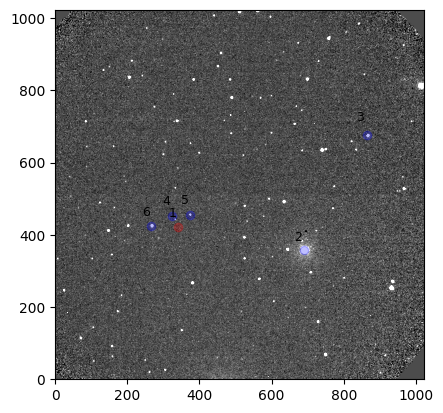

In [33]:
import os
import pandas as pd
from photometry import Photometry
from scripts.tools import sort_files
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import numpy as np
from photometry import Photometry

star_name = "GRB 230818A"
experiment = "all data"
src_path = os.path.join(
    "..",
    "Pol charact MOPTOP",
    "Scientific objects",
    star_name,
    experiment,
    star_name,
)

GOOD_IMAGE = "3_e_20230818_5_16_2_1.fits"
file = os.path.join(src_path, GOOD_IMAGE)
image = fits.getdata(file)
median = np.median(image)
std = np.median(np.abs(image - median))
plt.imshow(
    image, vmax=median + 7 * std, vmin=median - 3 * std, origin="lower", cmap="gray"
)

objects = [
    ("original", "19:03:33.2", "40:53:16.5"),
    ("comparison_1", "19:03:44.77", "40:52:07.4"),
    ("comparison_2", "19:03:42.6", "40:49:39"),
    ("candidate_1", "19:03:32", "40:53:11"),
    ("candidate_2", "19:03:33.39", "40:52:56.37"),
    ("candidate_3", "19:03:31", "40:53:34"),
]

phot = Photometry(file, objects)
for idx, _object in enumerate(phot.obj_list):
    name, x, y, *_ = _object.get_info()
    color = "b"
    if name == "original":
        color = "r"
    plt.plot(x, y, f"{color}o", alpha=0.25)
    plt.annotate(f"{idx+1}", (x * 0.99, y * 1.05), ha="right", va="bottom", fontsize=9)

plt.show()

# Create photometry.csv

In [39]:
objects_photometry = {}
objects = objects[1:]
for object in objects:
    objects_photometry[object[0]] = {
        "mjd": [],
        "xcoord": [],
        "ycoord": [],
        "star_photons": [],
    }

image_list = sort_files(src_path, "3_e")

for file in image_list:
    file_path = os.path.join(src_path, file)
    try:
        phot = Photometry(file_path, objects)
        phot.reset_object_coords()
        phot.calc_psf_radius()
        phot.calc_sky_photons()
        phot.calc_psf_photons()
        mjd = phot.get_mjd()
    except Exception:
        continue

    for _object in phot.obj_list:
        name, xcoord, ycoord, *_, star_photons = _object.get_info()
        objects_photometry[name]["mjd"].append(mjd)
        objects_photometry[name]["xcoord"].append(xcoord)
        objects_photometry[name]["ycoord"].append(ycoord)
        objects_photometry[name]["star_photons"].append(star_photons)

for obj_name, obj_info in objects_photometry.items():
    df = pd.DataFrame.from_dict(obj_info)
    csv_file = os.path.join(src_path, "..", "csv", f"{obj_name}.csv")
    df.sort_values(by=["mjd"])
    df.to_csv(csv_file, index=False)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-END to 60174.979820 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.979878 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.979994 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.980052 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.980110 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.980225 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.980341 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.980399 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.980457 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.980515 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.980572 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.980630 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.980688 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.980746 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.980804 from DATE-END'. [astropy.wcs.wcs]
Se

# Plot light curve

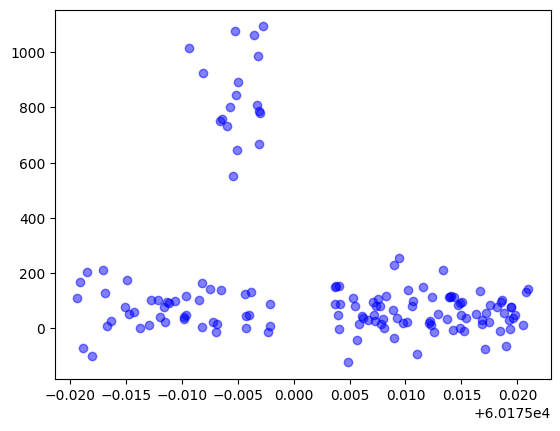

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np

star_name = "GRB 230818A"
experiment = "all data"
src_path = os.path.join(
    "..", "Pol charact MOPTOP", "Scientific objects", star_name, experiment
)

csv_file = os.path.join(src_path, "csv", "comparison_2.csv")
df = pd.read_csv(csv_file)
comp_1 = df["star_photons"]
csv_file = os.path.join(src_path, "csv", "comparison_2.csv")
df = pd.read_csv(csv_file)
comp_2 = df["star_photons"]
csv_file = os.path.join(src_path, "csv", "candidate_1.csv")
df = pd.read_csv(csv_file)
cand_1 = df["star_photons"]
csv_file = os.path.join(src_path, "csv", "candidate_2.csv")
df = pd.read_csv(csv_file)
cand_2 = df["star_photons"]
csv_file = os.path.join(src_path, "csv", "candidate_3.csv")
df = pd.read_csv(csv_file)
cand_3 = df["star_photons"]

cand_1 /= comp_2 + comp_1
cand_1 /= np.median(cand_1)

cand_2 /= comp_2 + comp_1
cand_2 /= np.median(cand_2)

cand_3 /= comp_2 + comp_1
cand_3 /= np.median(cand_3)

plt.plot(df["mjd"], cand_2, "bo", alpha=0.5)
plt.show()

# Plot object coordinates over the image

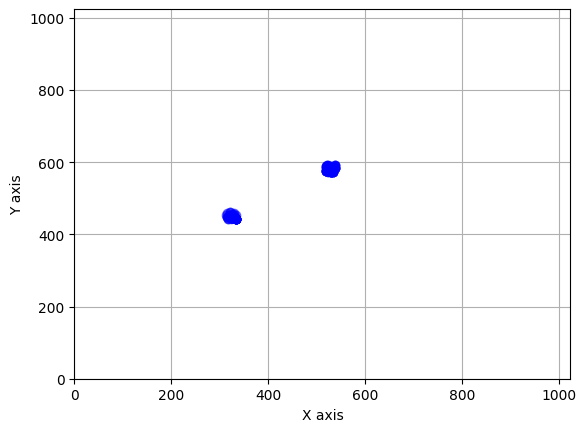

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import os

star_name = "GRB 230818A"
experiment = "all data"
src_path = os.path.join(
    "..", "Pol charact MOPTOP", "Scientific objects", star_name, experiment
)

csv_file = os.path.join(src_path, "csv", "candidate_1.csv")
df = pd.read_csv(csv_file)
plt.plot(df["xcoord"], df["ycoord"], "bo", alpha=0.5)
plt.xlim(0, 1024)
plt.ylim(0, 1024)
plt.xlabel(("X axis"))
plt.ylabel("Y axis")
plt.grid()
plt.show()